## Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed:

$$\begin{align}
w(t) =&\ \frac{d B(t)}{dt} \sim \mathcal{N}(0, \tau^{-1}dt)
\end{align}$$

The parameter $\tau$ represents the precision of the process. The same holds for the measurement noise.

### Solution steps

#### 1. Ignore nonlinear stiffness

For now, we ignore the nonlinear stiffness component by setting the parameter $b$ to 0. The state transition thus reduces to:

$$\begin{align}
m x''(t) + v x'(t) + a x(t) = u(t) + w(t) 
\end{align}$$

#### 2. Finite difference method

I'm using an implicit method, for stability reasons.
The backward difference for both derivative terms:

$$\begin{align}
x''(t) \approx&\ \frac{x(t) - 2x(t-h) + x(t-2h)}{h^2} = \frac{x_t - 2x_{t-1} + x_{t-2}}{\Delta t}\\
x'(t) \approx&\ \frac{x(t) - x(t-h)}{h} = \frac{x_t - x_{t-1}}{\Delta t}\\
\end{align}$$

where $h = \Delta t = t - (t-1) = 1$. A discretization of the Wiener process yields:

$$\begin{align}
w(t) = \frac{dB(t)}{dt} \approx \frac{B(t) - B(t-h)}{h} = \frac{B_t - B_{t-1}}{\Delta t} \sim \mathcal{N}(0, \tau^{-1}\Delta t) \, .
\end{align}$$

Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The DE can now be written as the following discrete-time system:

$$\begin{align}
m (x_t - 2x_{t-1} + x_{t-2}) + v (x_t - x_{t-1}) + a x_t =&\ u_t + w_t \\
(m + v + a) x_t + (-2m - v) x_{t-1} + m x_{t-2} =&\ u_t + w_t \\
x_t + \frac{-2m - v}{m + v + a} x_{t-1} + \frac{m}{m + v + a} x_{t-2} =&\ \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
x_t =&\ \frac{2m + v}{m + v + a} x_{t-1} + \frac{-m}{m + v + a} x_{t-2} + \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
\end{align}$$


#### 3. Change to shorthand notation:

I'm introducing some shorthand to clean the equation up a bit:

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a} \, .
\end{align}$$

This produces:
$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \eta w_t
\end{align}$$

Now I'm going to absorb $\eta$ into $w_t$ (using $\mathbb{V}[aX] = a^2\mathbb{V}[X]$):

$$\begin{align}
\mathbb{V}[\eta w_t] = \eta^2 \mathbb{V}[w_t] = \eta^2 \tau^{-1})
\end{align}$$

I will rename $\eta^2 \tau^{-1}$ as $\gamma^{-1}$. This yields

$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \tilde{w}_t
\end{align}$$

where $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. Given four equations and four unknowns, I can recover $m$, $v$, $a$ and $\tau$ from $\theta_1$, $\theta_2$, $\eta$ and $\gamma$.

#### 4. Convert to multivariate first-order form

The system now resembles an auto-regressive process:

$$ \underbrace{\begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} \theta_1 & \theta_2 \\ 1 & 0 \end{bmatrix}}_{A(\theta)} \underbrace{\begin{bmatrix} x_{t-1} \\ x_{t-2} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} \eta \\ 0 \end{bmatrix}}_{B(\eta)} u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, .$$

Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

#### 5. Convert to Gaussian probability

The state transition maps to

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + B(\eta) u_t, C(\gamma))$$

where $C(\gamma) = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & 0 \end{bmatrix}$ and the observation likelihood maps to

$$y_t \sim \mathcal{N}(c^{\top} z_t, \sigma^2)$$

where $c = \begin{bmatrix} 1 & 0 \end{bmatrix}$ and $e_t \sim \mathcal{N}(0, \sigma^2)$. I will first study a situation with known measurement noise, i.e., where $\sigma$ is fixed.

#### 6. Choose priors

The mass and stiffness are strictly positive parameters, but the viscous damping coefficient can be negative. As such, the $\theta$'s and $\eta$ can be both both positive and negative and modeled by Gaussian priors. Process precision $\gamma$ is strictly positive, so we will use a gamma distribution:

$$\begin{align}
\theta \sim&\ \mathcal{N}(m^{0}_\theta, v^{0}_\theta) \\
\eta \sim&\ \mathcal{N}(m^{0}_\eta, v^{0}_\eta) \\
\gamma \sim&\ \Gamma(a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1260


In [2]:
using Plots

viz = false

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


false

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [5]:
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [6]:
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1260
┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1260
  ** incremental compilation may be fatally broken for this module **



In [7]:
# Start graph
graph = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

# Observation selection variable
c = [1, 0]

# Measurement precision
σ = 1e4

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControl(θ, z_t, η, placeholder(:u_t), γ, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot(c, x_t), σ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15823105968324041952 -->
 
 15823105968324041952 
 
 placeholder_a_γ 
 
<!-- 5835684385461776523 -->
 
 5835684385461776523 
 
 placeholder_m_η 
 
<!-- 5311457984036717610 -->
 
 5311457984036717610 
 
 placeholder_m_θ 
 
<!-- 13408742384387570222 -->
 
 13408742384387570222 
 
 placeholder_m_z 
 
<!-- 4230605065916385441 -->
 
 4230605065916385441 
 
 ARC 
 x_t 
 
<!-- 14863659929375088804 -->
 
 14863659929375088804 
 
 𝒩 
 z_t 
 
<!-- 4230605065916385441--14863659929375088804 -->
 
 4230605065916385441--14863659929375088804 
 
 z_t 
 1 out 
 2 x 
 
<!-- 17261968801048108932 -->
 
 17261968801048108932 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 4230605065916385441--17261968801048108932 -->
 
 4230605065916385441--17261968801048108932 
 
 η 
 1 out 
 4 η 
 
<!-- 13677797751653974288 -->
 
 13677797751653974288 
 
 Gam 
 gamma_1 
 
<!-- 4230605065916385441--13677797751653974288 -->
 
 4230605065916385441--13677797751653974288 
 
 γ 
 1 out 
 6 γ 
 
<!-- 11183352680051410172 -->
 
 11183352680051410172 
 
 placeholder_u_t 
 
<!-- 4230605065916385441--11183352680051410172 -->
 
 4230605065916385441--11183352680051410172 
 
 u_t 
 1 out 
 5 u 
 
<!-- 1740745747805210415 -->
 
 1740745747805210415 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 4230605065916385441--1740745747805210415 -->
 
 4230605065916385441--1740745747805210415 
 
 θ 
 1 out 
 3 θ 
 
<!-- 4205970627749190409 -->
 
 4205970627749190409 
 
 placeholder_w_z 
 
<!-- 4499550961601736525 -->
 
 4499550961601736525 
 
 placeholder_w_θ 
 
<!-- 14863659929375088804--13408742384387570222 -->
 
 14863659929375088804--13408742384387570222 
 
 m_z 
 1 out 
 2 m 
 
<!-- 14863659929375088804--4205970627749190409 -->
 
 14863659929375088804--4205970627749190409 
 
 w_z 
 1 out 
 3 w 
 
<!-- 1083658079326152997 -->
 
 1083658079326152997 
 
 placeholder_w_η 
 
<!-- 17261968801048108932--5835684385461776523 -->
 
 17261968801048108932--5835684385461776523 
 
 m_η 
 1 out 
 2 m 
 
<!-- 17261968801048108932--1083658079326152997 -->
 
 17261968801048108932--1083658079326152997 
 
 w_η 
 1 out 
 3 w 
 
<!-- 17916696035075771345 -->
 
 17916696035075771345 
 
 clamp_2 
 
<!-- 11026013830914025705 -->
 
 11026013830914025705 
 
 placeholder_b_γ 
 
<!-- 9479556332673613604 -->
 
 9479556332673613604 
 
 dot 
 dotproduct_1 
 
<!-- 9479556332673613604--4230605065916385441 -->
 
 9479556332673613604--4230605065916385441 
 
 x_t 
 1 y 
 2 in1 
 
<!-- 4300776932997914039 -->
 
 4300776932997914039 
 
 clamp_1 
 
<!-- 9479556332673613604--4300776932997914039 -->
 
 9479556332673613604--4300776932997914039 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 15107905651888429608 -->
 
 15107905651888429608 
 
 placeholder_y_t 
 
<!-- 9953580708397487965 -->
 
 9953580708397487965 
 
 𝒩 
 y_t 
 
<!-- 15107905651888429608--9953580708397487965 -->
 
 15107905651888429608--9953580708397487965 
 
 y_t 
 1 out 
 1 out 
 
<!-- 13677797751653974288--15823105968324041952 -->
 
 13677797751653974288--15823105968324041952 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 13677797751653974288--11026013830914025705 -->
 
 13677797751653974288--11026013830914025705 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 9953580708397487965--17916696035075771345 -->
 
 9953580708397487965--17916696035075771345 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 9953580708397487965--9479556332673613604 -->
 
 9953580708397487965--9479556332673613604 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 1740745747805210415--5311457984036717610 -->
 
 1740745747805210415--5311457984036717610 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 1740745747805210415--4499550961601736525 -->
 
 1740745747805210415--4499550961601736525 
 
 w_θ 
 1 out 
 3 w

In [24]:
# Infer an algorithm
q = PosteriorFactorization(z_t, x_t, θ, η, γ, ids=[:z, :x, :θ, :η, :γ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

In [9]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_θ = (ones(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_η = (ones(1,T+1), 0.1*ones(1,T+1))
params_γ = (0.1*ones(1,T+1), 0.01*ones(1,T+1))

# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_x[1][:,t+1] = unsafeMean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:02:03:54


### Visualize results

In [10]:
viz = true

true

In [39]:
# Extract mean of state marginals
estimated_states = params_x[1][1,2:end]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 10
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1400,600), xlabel="time (t)", ylabel="response")
    Plots.plot!(1:n:T, estimated_states[1:n:T], color="red", linewidth=1, label="estimated")
#     Plots.savefig(p1, "viz/estimated_states01.png")
end

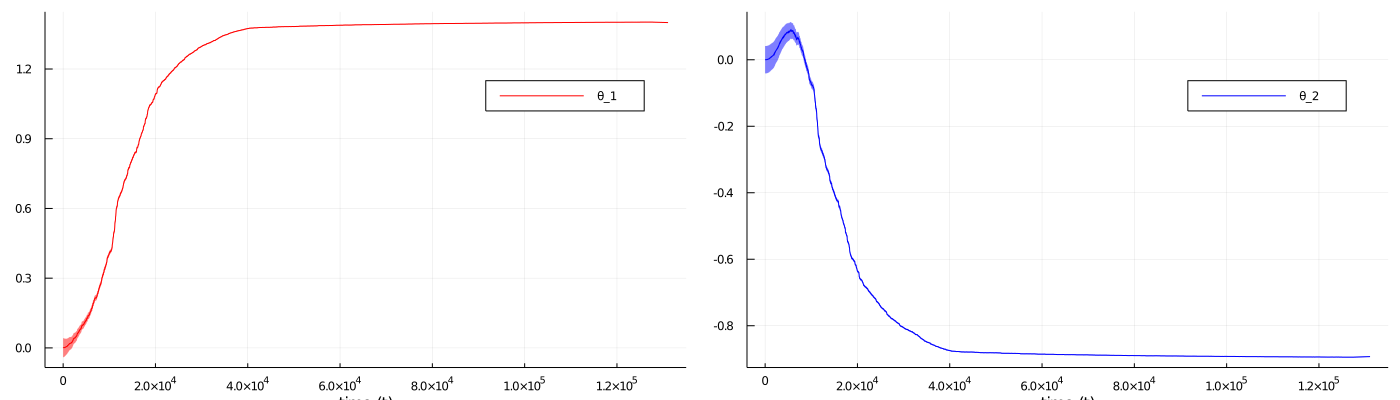

In [12]:
# Extract mean of coefficient marginals
estimated_coeffs_1_mean = params_θ[1][1,2:end]
estimated_coeffs_1_std = sqrt.(inv.(params_θ[2][1,1,2:end]))
estimated_coeffs_2_mean = params_θ[1][2,2:end]
estimated_coeffs_2_std = sqrt.(inv.(params_θ[2][2,2,2:end]))

if viz
    
#     # Plot both coefficients within the same figure
#     Plots.plot(1:n:T, estimated_coeffs_1_mean[1:n:T], ribbon=[estimated_coeffs_1_std[1:n:T], estimated_coeffs_1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)", ylim=[-1.5, 1.5])
#     Plots.plot!(1:n:T, estimated_coeffs_2_mean[1:n:T], ribbon=[estimated_coeffs_2_std[1:n:T], estimated_coeffs_2_std[1:n:T]], color="blue", label="θ_2")
# #     Plots.savefig("viz/estimated_coeffs.png")
    
    # Plot both coefficients next to each other
    p2a = Plots.plot(1:n:T, estimated_coeffs_1_mean[1:n:T], ribbon=[estimated_coeffs_1_std[1:n:T], estimated_coeffs_1_std[1:n:T]], color="red", label="θ_1", xlabel="time (t)")
    p2b = Plots.plot(1:n:T, estimated_coeffs_2_mean[1:n:T], ribbon=[estimated_coeffs_2_std[1:n:T], estimated_coeffs_2_std[1:n:T]], color="blue", label="θ_2", xlabel="time (t)")
    p2 = plot(p2a, p2b, size=(1400,400))
#     Plots.savefig(p2, "viz/estimated_coeffs_subp.png")
end

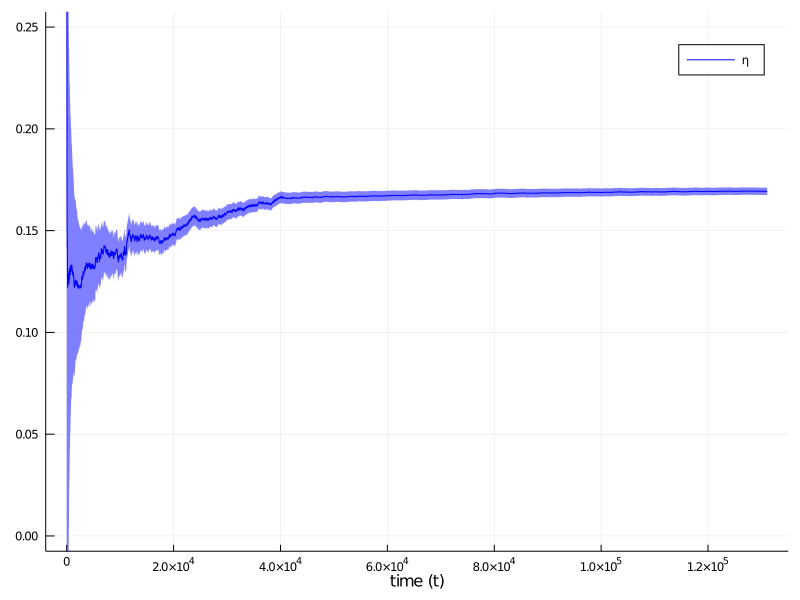

In [13]:
# Extract mean of control coefficient marginals
estimated_ccoeff_mean = params_η[1][1,2:end]
estimated_ccoeff_std = sqrt.(inv.(params_η[2][1,2:end]))

if viz
    # Plot both coefficients next to each other
    p3 = Plots.plot(1:n:T, estimated_ccoeff_mean[1:n:T], ribbon=[estimated_ccoeff_std[1:n:T], estimated_ccoeff_std[1:n:T]], color="blue", label="η", xlabel="time (t)", size=(800,600), ylim=[0.0, 0.25])
#     Plots.savefig(p3, "viz/estimated_ccoeff.png")
end

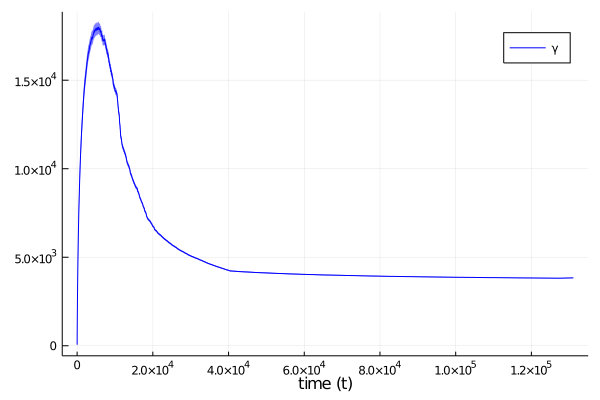

In [14]:
# Extract mean of process precision marginals
estimated_pnoise_mean = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
estimated_pnoise_std = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

if viz
    # Plot both coefficients next to each other
    p4 = Plots.plot(1:n:T, estimated_pnoise_mean[1:n:T], ribbon=[estimated_pnoise_std[1:n:T], estimated_pnoise_std[1:n:T]],color="blue", label="γ", xlabel="time (t)")
#     Plots.savefig(p4, "viz/estimated_pnoise.png")
end

## Solving nonlinear system of equations

We currently have estimates for $\theta_1$, $\theta_2$, and $\eta$. But we want to know the original coefficients, $m$, $v$ and $a$, which actually have a physical meaning. To obtain estimates for those, we have to solve the following nonlinear system of equations:

$$\begin{align} 
\hat{\theta}_1 =&\ \frac{2m + v}{m + v + a} \\
\hat{\theta}_2 =&\ \frac{-m}{m + v + a} \\
\hat{\eta} =&\ \frac{1}{m + v + a} \\
\hat{\gamma}^{-1} =&\ \frac{1}{\tau (m + v + a)^2}
\end{align}$$

Implementation using NLsolve.jl

In [15]:
using NLsolve

In [40]:
# Current estimates of parameters
global estimates = [estimated_coeffs_1_mean[end], estimated_coeffs_2_mean[end], estimated_ccoeff_mean[end], inv(estimated_pnoise_mean[end])]

4-element Array{Float64,1}:
  1.3998081437787575
 -0.8929167408587348
  0.16931247444867797
  0.0002607540354193496

In [41]:
# Define nonlinear system of equations
function F!(F, x)
    F[1] = (2*x[1] + x[2])/(x[1] + x[2] + x[3])  - estimates[1]
    F[2] = (-x[1])/(x[1] + x[2] + x[3]) - estimates[2]
    F[3] = 1/(x[1] + x[2] + x[3]) - estimates[3]
    F[4] = 1/(x[4]*(x[1] + x[2] + x[3])^2) - estimates[4] 
end

# Jacobian of each equation
function J!(J, x)
    
    # F[1]
    J[1, 1] = (x[2] + 2*x[3])/(x[1] + x[2] + x[3])^2
    J[1, 2] = (x[3] - x[1])/(x[1] + x[2] + x[3])^2
    J[1, 3] = (-2*x[1] - x[2])/(x[1] + x[2] + x[3])^2
    J[1, 4] = 0.
    
    # F[2]
    J[2, 1] = (x[2] + x[3])/(x[1] + x[2] + x[3])^2
    J[2, 2] = x[1]/(x[1] + x[2] + x[3])^2
    J[2, 3] = x[1]/(x[1] + x[2] + x[3])^2
    J[2, 4] = 0.
    
    # F[3]
    J[3, 1] = -1/(x[1] + x[2] + x[3])^2
    J[3, 2] = -1/(x[1] + x[2] + x[3])^2
    J[3, 3] = -1/(x[1] + x[2] + x[3])^2
    J[3, 4] = 0.
    
    # F[4]
    J[4, 1] = -1/(2*x[4]*(x[1] + x[2] + x[3])^(3/2))
    J[4, 2] = -1/(2*x[4]*(x[1] + x[2] + x[3])^(3/2))
    J[4, 3] = -1/(2*x[4]*(x[1] + x[2] + x[3])^(3/2))
    J[4, 4] = -1/(x[4]^2*sqrt(x[1] + x[2] + x[3]))
    
end

# Call solver
# x_solved = nlsolve(F!, J!, [1. 1. 1. 1.])
x_solved = nlsolve(F!, [1. 1. 1. 1.], autodiff=:forward)

# Extract new estimates
global m, v, a, τ = x_solved.zero

1×4 Array{Float64,2}:
 5.27378  -2.27996  2.91242  109.935

So, in total we estimate the dynamical parameters as follows:

In [42]:
println("m = " *string(m))
println("v = " *string(v))
println("a = " *string(a))
println("τ = " *string(τ))

m = 5.273779996224649
v = -2.279958043231625
a = 2.9124174027085563
τ = 109.93523181919981


Now, I'm going to estimate the dynamical parameters for the entire trajectory. Note that I could do this at inference time as well.

In [43]:
m = zeros(T,1)
v = zeros(T,1)
a = zeros(T,1)
τ = zeros(T,1)

# Extract means of marginals
estimated_θ1 = params_θ[1][1,2:end]
estimated_θ2 = params_θ[1][2,2:end]
estimated_η = params_η[1][1,2:end]
estimated_γ = inv.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end])

for t = 1:T
    
    function F!(F, x)
        F[1] = (2*x[1] + x[2])/(x[1] + x[2] + x[3])  - estimated_θ1[t]
        F[2] = (-x[1])/(x[1] + x[2] + x[3]) - estimated_θ2[t]
        F[3] = 1/(x[1] + x[2] + x[3]) - estimated_η[t]
        F[4] = 1/(x[4]*(x[1] + x[2] + x[3])^2) - estimated_γ[t] 
    end
    
    # Call solver
#     x_solved = nlsolve(F!, J!, [1. 1. 1. 1.])
    x_solved = nlsolve(F!, [0.1 0.1 0.1 0.1], autodiff=:forward)

    # Extract new estimates
    m[t], v[t], a[t], τ[t] = x_solved.zero
    
end

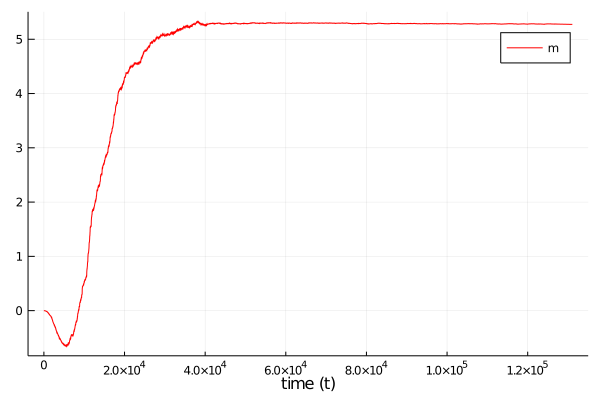

In [44]:
# Plot belief evolution for mass
Plots.plot(1:n:T, m[1:n:T], color="red", label="m", xlabel="time (t)")

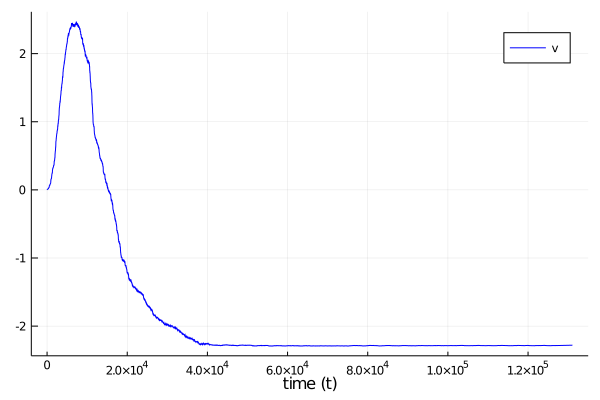

In [45]:
# Plot belief evolution for friction coefficient
Plots.plot(1:n:T, v[1:n:T], color="blue", label="v", xlabel="time (t)")

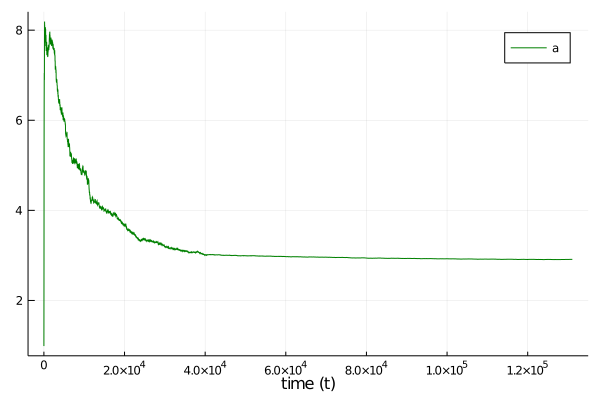

In [46]:
# Plot belief evolution for linear stiffness
Plots.plot(1:n:T, a[1:n:T], color="green", label="a", xlabel="time (t)")

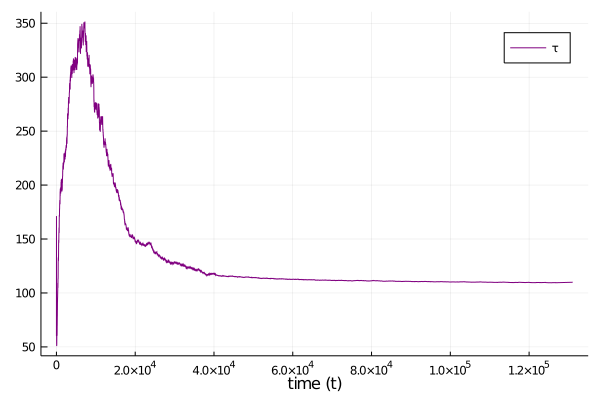

In [47]:
# Plot belief evolution for process precision
Plots.plot(1:n:T, τ[1:n:T], color="purple", label="τ", xlabel="time (t)")